# Challenge: The boston marathon

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.



In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from sklearn import metrics
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth,SpectralClustering,AffinityPropagation


from sklearn.datasets import make_blobs
%matplotlib inline

### Loading data

In [2]:
marathon = pd.read_csv('results.csv')
marathon.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [3]:
marathon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


### Data Exploration

In [4]:
def fillmissingvalues(columntofill,columnreference):

    '''
    function: fillmissingvalues fills a column with this value '-' and convert it to numeric type
              It applies IMPUTATION technique following these calculations:
                  - calculate means of the reference column and the column to fill
                  - get the difference between those means
                  - substract the means difference to the reference column

    arguments: column to fill and reference column

    '''
    referencemean = pd.to_numeric(marathon[columnreference],downcast='float',errors='coerce').mean()
    columnmean = pd.to_numeric(marathon[columntofill],downcast='float',errors='coerce').mean()
    difference = referencemean - columnmean

    marathon[columntofill] = np.where(marathon[columntofill]=='-',marathon[columnreference]-difference,marathon[columntofill])
    marathon[columntofill] = round(pd.to_numeric(marathon[columntofill],downcast='float',errors='coerce'),2)
    
    


def convertbib(bib):
    '''
    function: fillmissingvalues fills a column with this value '-' and convert it to numeric type
              It applies IMPUTATION technique following these calculations:
                  - calculate means of the reference column and the column to fill
                  - get the difference between those means
                  - substract the means difference to the reference column

    arguments: column to fill and reference column

    '''
    b = str(bib)
    if b[0] == 'W':      
        return 1
    else:
        return 0




def is_a_numericalColumn(x):
    '''
    function: is_a_numericalColumn verifies if the values in a given column are numbers
    arguments: column to be verified
    return : alist with non numerical values
    '''
    lista=[]    
    for i in marathon[x]:
        try:
            i = float(i)
        except:
            lista.append(i)

    return lista


def getagegroup(age):
    '''
    function: getagegroup assigns a group based on age
    arguments: age column
    returns: age group (see table below)

    age     group
    18-34 : 0
    35-39 : 1
    40-44 : 2
    ..
    75-79 : 9
    80 > 10

    '''
    min_age = 34
    groups_elements = 5
    
    if age <= min_age:
        return 0
    elif age > 79:
        return 10
    else:
        r = (age - min_age) % groups_elements
        if r == 0:
            return int((age - min_age) / groups_elements)
        else:
            return int(((age - min_age) / groups_elements) + 1)
        

In [5]:
#Finding null values

for column in marathon.columns:
    
    if round((marathon[column].isnull().sum() * 100)/marathon[column].isnull().count(),3) > 0.0:
        print('Percentage of null values for {} variable: {}% '.format(column,round((marathon[column].isnull().sum() * 100)/marathon[column].isnull().count(),3)))


Percentage of null values for ctz variable: 96.111% 
Percentage of null values for state variable: 8.054% 
Percentage of null values for city variable: 0.003% 


In [6]:
#Removing name and ctz columns
marathon = marathon.drop(columns=['name','ctz'])

marathon = marathon.dropna(subset=['city'])

#Cleaning state column
marathon['state'] =  marathon['state'].astype('str') 
marathon['state'] = marathon['state'].str.replace('nan','Foreing State')


#Convert gender variable to 0 and 1
marathon['gender'] = np.where(marathon['gender']=='M',0,1)

#Convert bib variable to numeric variable
marathon['bib'] = marathon['bib'].apply(convertbib)

#Generate a column age_group
marathon['age_group'] = marathon['age'].apply(getagegroup)


In [7]:
#Find non numerical columns

columns_tofloat = []
categorical = marathon.select_dtypes(include=['object'])

for column in categorical:
    columns_tofloat.append(column)

#drop categorical variables from columns_toconvert list


columns_tofloat.remove('city')
columns_tofloat.remove('country')

#Convert variables to float type

for i in columns_tofloat:
    marathon[i] =  pd.to_numeric(marathon[i],downcast='float',errors='ignore')
    
marathon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31983 entries, 0 to 31983
Data columns (total 20 columns):
10k          31983 non-null object
division     31983 non-null int64
25k          31983 non-null object
gender       31983 non-null int64
age          31983 non-null int64
official     31983 non-null float64
bib          31983 non-null int64
genderdiv    31983 non-null int64
35k          31983 non-null object
overall      31983 non-null int64
pace         31983 non-null float64
state        31983 non-null object
30k          31983 non-null object
5k           31983 non-null object
half         31983 non-null object
20k          31983 non-null object
country      31983 non-null object
city         31983 non-null object
40k          31983 non-null object
age_group    31983 non-null int64
dtypes: float64(2), int64(7), object(11)
memory usage: 5.1+ MB


In [8]:
#Find a reason why columns 5k','10k','20k','half','25k','30k','35k' and '40k' are still object type

columnlist = ['5k','10k','20k','half','25k','30k','35k','40k','official']

for c in columnlist:
    
    columnK = is_a_numericalColumn(c)
    print('No numerical elements in column {}:'.format(c))
    print(columnK)



No numerical elements in column 5k:
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
No numerical elements in column 10k:
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
No numerical elements in column 20k:
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
No numerical elements in column half:
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-'

In [9]:
#Fill '-' values in ['5k','10k','20k','half','25k','30k','35k','40k']

fillmissingvalues('40k','official')
fillmissingvalues('35k','40k')
fillmissingvalues('30k','35k')
fillmissingvalues('25k','30k')
fillmissingvalues('half','25k')
fillmissingvalues('20k','half')
fillmissingvalues('10k','20k')
fillmissingvalues('5k','10k')


In [10]:
marathon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31983 entries, 0 to 31983
Data columns (total 20 columns):
10k          31983 non-null float32
division     31983 non-null int64
25k          31983 non-null float32
gender       31983 non-null int64
age          31983 non-null int64
official     31983 non-null float64
bib          31983 non-null int64
genderdiv    31983 non-null int64
35k          31983 non-null float32
overall      31983 non-null int64
pace         31983 non-null float64
state        31983 non-null object
30k          31983 non-null float32
5k           31983 non-null float32
half         31983 non-null float32
20k          31983 non-null float32
country      31983 non-null object
city         31983 non-null object
40k          31983 non-null float32
age_group    31983 non-null int64
dtypes: float32(8), float64(2), int64(7), object(3)
memory usage: 4.1+ MB


All null values are in yellow


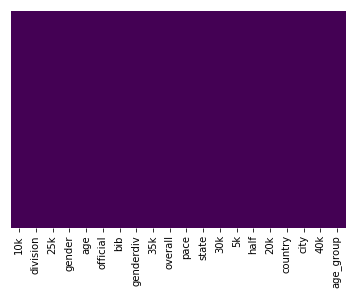

In [11]:
#Looking for null values

print('All null values are in yellow')
sns.heatmap(marathon.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [12]:
marathon.head()

,10k,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k,age_group
0,17.370001,8,47.669998,0,47,85.25,1,8,71.400002,8,3.27,Foreing State,59.180000,8.020000,39.720001,37.650002,JPN,Fukuoka,80.430000,3
1,32.580002,1,82.430000,1,33,138.95,0,1,116.370003,21,5.30,Foreing State,99.330002,16.219999,69.470001,65.830002,KEN,Eldoret,132.100006,0
2,16.620001,1,45.799999,0,41,80.60,1,1,67.419998,1,3.08,Foreing State,56.450001,7.750000,38.029999,36.099998,RSA,Paarl,76.099998,2
3,32.570000,3,82.430000,1,24,140.58,0,3,116.370003,27,5.37,Foreing State,99.330002,16.200001,69.470001,65.830002,ETH,Shoa,132.949997,0
4,17.120001,2,46.369999,0,40,81.23,1,2,67.830002,2,3.10,Foreing State,57.029999,8.020000,38.599998,36.580002,JPN,Nogata Fukuoka,76.720001,2


In [13]:
marathon.corr()

,10k,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,age_group
10k,1.000000,0.467184,0.963544,0.271903,0.166136,0.919481,-0.135937,0.790507,0.937176,0.893262,0.919573,0.953098,0.979014,0.979585,0.981233,0.923506,0.177725
division,0.467184,1.000000,0.485347,0.125825,-0.577243,0.515367,-0.045524,0.470742,0.510453,0.514496,0.515631,0.500275,0.455082,0.481211,0.480693,0.517448,-0.583958
25k,0.963544,0.485347,1.000000,0.257390,0.156707,0.965433,-0.112756,0.811795,0.981714,0.910190,0.965043,0.993296,0.918614,0.993423,0.992599,0.969606,0.168943
gender,0.271903,0.125825,0.257390,1.000000,-0.208845,0.204417,-0.019791,-0.166773,0.229258,0.246645,0.204729,0.246677,0.263353,0.268597,0.270067,0.210850,-0.205297
age,0.166136,-0.577243,0.156707,-0.208845,1.000000,0.166453,-0.027957,0.306859,0.157500,0.201138,0.166606,0.156811,0.154110,0.164724,0.164169,0.160446,0.973831
official,0.919481,0.515367,0.965433,0.204417,0.166453,1.000000,-0.106165,0.878361,0.993187,0.954233,0.999897,0.981537,0.874475,0.957301,0.955111,0.999305,0.179867
bib,-0.135937,-0.045524,-0.112756,-0.019791,-0.027957,-0.106165,1.000000,-0.068842,-0.104346,-0.070216,-0.106270,-0.108449,-0.141724,-0.120600,-0.120871,-0.105760,-0.024923
genderdiv,0.790507,0.470742,0.811795,-0.166773,0.306859,0.878361,-0.068842,1.000000,0.855606,0.909209,0.878790,0.836050,0.759617,0.811948,0.809939,0.872833,0.321299
35k,0.937176,0.510453,0.981714,0.229258,0.157500,0.993187,-0.104346,0.855606,1.000000,0.942581,0.993032,0.993935,0.891193,0.974335,0.972452,0.995551,0.170317
overall,0.893262,0.514496,0.910190,0.246645,0.201138,0.954233,-0.070216,0.909209,0.942581,1.000000,0.954766,0.930249,0.858741,0.914221,0.912763,0.951680,0.216644


--- Runtime: 0.17384791374206543 seconds ---


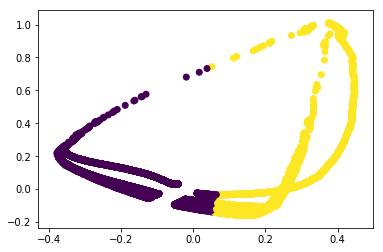

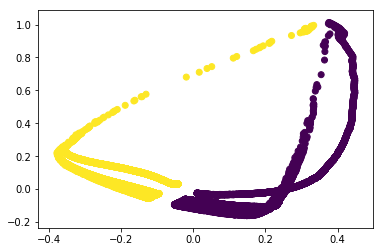

Comparing k-means clusters against the data:
gender     0      1
row_0              
0       7978  14331
1       9639     35


In [14]:
# Normalize the data.
#X = marathon.drop(['state','country','city','gender'], axis=1)
X = marathon[['5k','10k','20k','half','25k','30k','35k','40k','official','overall','pace','age','genderdiv','division','bib']]
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(3).fit_transform(X_norm)

#X_pca = normalize(X)

#Calculate start time
start_time = time.time()

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

y = marathon['gender']
#Printing runtime
print("--- Runtime: %s seconds ---" % (time.time() - start_time))


# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.show()


# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

--- Runtime: 2.324326992034912 seconds ---


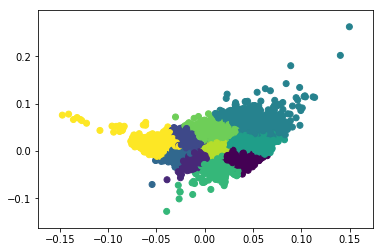

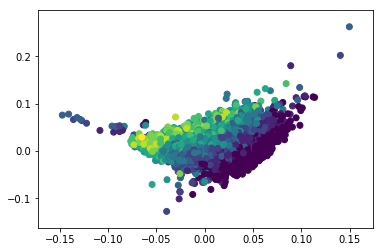

Comparing k-means clusters against the data:
age_group    0     1     2     3    4    5    6    7   8   9   10
row_0                                                            
0          2518   373   204    74   19    5    0    0   0   0   0
1          1300  1409  1246   780  220   77   29   12   7   1   0
2            22   112   460   933  934  751  452  211  54  13   5
3            94   444  1055  1453  946  350  139   42  10   1   2
4           133    58    81    80   59   44   24    8   6   3   0
5          1086   370   320   169   87   27    7    1   1   0   0
6          2666   386   204    66   40   17    7    2   0   0   0
7            58   141   251   396  444  336  233  123  37   6   1
8           814   911  1053   894  455  206   90   33   5   2   0
9            20    11    96   378  763  734  472  225  66  19   1


In [16]:
# Normalize the data.
#X = marathon.drop(['state','country','city','gender'], axis=1)
X = marathon[['5k','10k','20k','half','25k','30k','35k','40k','official','pace','age','official']]
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(5).fit_transform(X_norm)

#X_pca = normalize(X)

#Calculate start time
start_time = time.time()

# Calculate predicted values.
y_pred = KMeans(n_clusters=10, random_state=42).fit_predict(X_pca)

y = marathon['age_group']
#Printing runtime
print("--- Runtime: %s seconds ---" % (time.time() - start_time))


# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.show()


# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

________________________

By: Wendy Navarrete
September 2019